## 0 Imports

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from dateutil.relativedelta import relativedelta
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, r2_score, accuracy_score
import datetime
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.miscmodels.ordinal_model import OrderedModel

import statsmodels.api as sm

from sklearn.model_selection import KFold

### 0.1 Helper Functions

In [36]:
pd.set_option('display.float_format', '{:.2f}'.format)

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mse = mean_squared_error(y, yhat)
    rmse = np.sqrt(mse)
    r2 = r2_score(y, yhat)


    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MSE': mse,
                         'RMSE': rmse,
                         'R²': r2
                         }, 
                        index=[0])

def cross_validation(X, y, model, kfold=5):
    kf = KFold(n_splits=kfold, shuffle=True, random_state=42)
    
    mae_list = []
    mse_list = []
    rmse_list = []
    r2_list = []
    
    #separando a base de validação em 1/n partes e treino em n-1/n partes 
    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        # Treinando o modelo
        model.fit(X_train, y_train)
        
        # Fazendo previsões
        y_pred = model.predict(X_val)
        
        # Calculando as métricas usando sklearn
        mae = mean_absolute_error(y_val, y_pred)
        mse = mean_squared_error(y_val, y_pred)
        rmse = np.sqrt(mse)  
        r2 = r2_score(y_val, y_pred)
        
        mae_list.append(mae)
        mse_list.append(mse)
        rmse_list.append(rmse)
        r2_list.append(r2)

    #efetua-se a média de cada erro entre os n modelos
    return pd.DataFrame({
        'MAE': [np.mean(mae_list), np.std(mae_list)],
        'MSE': [np.mean(mse_list), np.std(mse_list)],
        'RMSE': [np.mean(rmse_list), np.std(rmse_list)],
        'R²': [np.mean(r2_list), np.std(r2_list)]
    }, index=['Mean', 'Std'])


def cross_validation_list(X, y, model, kfold=5):
    kf = KFold(n_splits=kfold, shuffle=True, random_state=42)
    
    mae_list = []
    mse_list = []
    rmse_list = []
    
    # Separando a base de validação em 1/n partes e treino em n-1/n partes 
    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        # Treinando o modelo
        model.fit(X_train, y_train)
        
        # Fazendo previsões
        y_pred = model.predict(X_val)
        
        # Calculando as métricas usando sklearn
        mae = mean_absolute_error(y_val, y_pred)
        mse = mean_squared_error(y_val, y_pred)
        rmse = np.sqrt(mse)  
        
        mae_list.append(mae)
        mse_list.append(mse)
        rmse_list.append(rmse)
    
    # Retornando as listas de erros
    return {
        'MAE': mae_list,
        'MSE': mse_list,
        'RMSE': rmse_list
    }

def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data


### 0.2 - Load Data

In [37]:
data_raw = pd.read_csv('C:/Users/Alexandre/Documents/TCC - Data Science e Analytics/beer_reviews.csv')

In [38]:
data = data_raw.copy()

In [39]:
data = data[['review_overall', 'review_taste', 'review_appearance', 'review_aroma', 'review_palate', 'review_time' ]]

## 1 Data Description

### 1.1 Data Preview

In [40]:
data.head(5)

,review_overall,review_taste,review_appearance,review_aroma,review_palate,review_time
0,1.50,1.50,2.50,2.00,1.50,1234817823
1,3.00,3.00,3.00,2.50,3.00,1235915097
2,3.00,3.00,3.00,2.50,3.00,1235916604
3,3.00,3.00,3.50,3.00,2.50,1234725145
4,4.00,4.50,4.00,4.50,4.00,1293735206


### 1.2 Data Dimension

In [41]:
print('Number of rows: {}'.format(data.shape[0]))
print('Number of columns: {}'.format(data.shape[1]))

Number of rows: 1586614
Number of columns: 6


### 1.3 Rename Columns

### 1.3 Data Types

In [42]:
data.dtypes

review_overall       float64
review_taste         float64
review_appearance    float64
review_aroma         float64
review_palate        float64
review_time            int64
dtype: object

### 1.4 Change dtypes


In [43]:
data['review_time'] = pd.to_datetime(data['review_time'], unit='s')


### 1.5 Check NA's


In [44]:
data.isna().sum()

review_overall       0
review_taste         0
review_appearance    0
review_aroma         0
review_palate        0
review_time          0
dtype: int64

### 1.5 Quality Check

In [45]:
num_attributes = data.select_dtypes(include=['int64','float64'])

#medidas de Tendência Central
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#medidas de dispersão

dm1 = pd.DataFrame(num_attributes.apply(np.min)).T
dm2 = pd.DataFrame(num_attributes.apply(np.max)).T
dm3 = pd.DataFrame(num_attributes.apply(np.std)).T
dm4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
dm5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
dm6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concatenando para melhorar a visualização
numerical_metrics = pd.concat([dm1,dm2,dm4,ct1,ct2,dm3,dm5,dm6]).T.reset_index()

#renomeando as colunas
numerical_metrics.columns = ['attribute','min','max','range','mean','median','std','skew','kurtosis']

#exibindo o resultado
numerical_metrics

,attribute,min,max,range,mean,median,std,skew,kurtosis
0,review_overall,0.00,5.00,5.00,3.82,4.00,0.72,-1.02,1.63
1,review_taste,1.00,5.00,4.00,3.79,4.00,0.73,-0.97,1.34
2,review_appearance,0.00,5.00,5.00,3.84,4.00,0.62,-0.90,1.74
3,review_aroma,1.00,5.00,4.00,3.74,4.00,0.70,-0.84,1.15
4,review_palate,1.00,5.00,4.00,3.74,4.00,0.68,-0.87,1.30


In [46]:
#criando dfs que contem a quantidade de notas por categoria
d1 = pd.DataFrame(data['review_overall'].value_counts().reset_index().sort_values(by='index', ascending=True))
d2 = pd.DataFrame(data['review_appearance'].value_counts().reset_index().sort_values(by='index',ascending=True))
d3 = pd.DataFrame(data['review_taste'].value_counts().reset_index().sort_values(by='index',ascending=True))
d4 = pd.DataFrame(data['review_palate'].value_counts().reset_index().sort_values(by='index',ascending=True))
d5 = pd.DataFrame(data['review_aroma'].value_counts().reset_index().sort_values(by='index',ascending=True))

quality_check = pd.concat([d1, d2, d3, d4, d5], axis=1, join='outer')
quality_check = quality_check.loc[:, ~quality_check.columns.duplicated()]
quality_check

,index,review_overall,review_appearance,review_taste,review_palate,review_aroma
9,0.00,7,7,NaN,NaN,NaN
8,1.00,10954,3323,9991.00,6874.00,6873.00
7,1.50,12975,6147,15128.00,11045.00,12524.00
6,2.00,38225,25414,41992.00,38333.00,42566.00
5,2.50,58523,39493,66534.00,62190.00,64117.00
3,3.00,165644,166009,166860.00,206932.00,200030.00
2,3.50,301817,288108,324541.00,253102.00,271450.00
0,4.00,582764,674186,541429.00,606711.00,557383.00
1,4.50,324385,318529,336162.00,338585.00,365312.00
4,5.00,91320,65398,83977.00,62842.00,66359.00


### 1.6 Fillout Inconsistent data

In [47]:
#para as sete observações iguais a 0 em review_overall e review_appearance atribuir a nota mínima
data.loc[(data['review_overall'] == 0) & (data['review_appearance'] == 0), ['review_overall', 'review_appearance']] = 1

### 1.7 Descriptive Statistical


In [48]:
num_attributes = data.select_dtypes(include=['int64','float64'])
cat_attributes = data.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

#### 1.7.1 Sensorial Variables Num Attributes

In [49]:
#medidas de Tendência Central
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#medidas de dispersão

dm1 = pd.DataFrame(num_attributes.apply(np.min)).T
dm2 = pd.DataFrame(num_attributes.apply(np.max)).T
dm3 = pd.DataFrame(num_attributes.apply(np.std)).T
dm4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
dm5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
dm6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concatenando para melhorar a visualização
numerical_metrics = pd.concat([dm1,dm2,dm4,ct1,ct2,dm3,dm5,dm6]).T.reset_index()

#renomeando as colunas
numerical_metrics.columns = ['attribute','min','max','range','mean','median','std','skew','kurtosis']

#exibindo o resultado
numerical_metrics

,attribute,min,max,range,mean,median,std,skew,kurtosis
0,review_overall,1.00,5.00,4.00,3.82,4.00,0.72,-1.02,1.63
1,review_taste,1.00,5.00,4.00,3.79,4.00,0.73,-0.97,1.34
2,review_appearance,1.00,5.00,4.00,3.84,4.00,0.62,-0.90,1.73
3,review_aroma,1.00,5.00,4.00,3.74,4.00,0.70,-0.84,1.15
4,review_palate,1.00,5.00,4.00,3.74,4.00,0.68,-0.87,1.30


#### 1.7.2 Sensorial Cat Num Attributes

In [50]:
#criando dfs que contem a quantidade de notas por categoria
d1 = pd.DataFrame(data['review_overall'].value_counts().reset_index().sort_values(by='index', ascending=True))
d2 = pd.DataFrame(data['review_appearance'].value_counts().reset_index().sort_values(by='index',ascending=True))
d3 = pd.DataFrame(data['review_taste'].value_counts().reset_index().sort_values(by='index',ascending=True))
d4 = pd.DataFrame(data['review_palate'].value_counts().reset_index().sort_values(by='index',ascending=True))
d5 = pd.DataFrame(data['review_aroma'].value_counts().reset_index().sort_values(by='index',ascending=True))

cat_metrics = pd.concat([d1, d2, d3, d4, d5], axis=1, join='outer')
cat_metrics = cat_metrics.loc[:, ~cat_metrics.columns.duplicated()]
cat_metrics.rename(columns={'index':'nota', 
                            'review_overall':'review_overall_qty',
                            'review_appearance':'review_appearance_qty',
                            'review_taste':'review_taste_qty',
                            'review_palate':'review_palate_qty',
                            'review_aroma':'review_aroma_qty',}, inplace=True)
cat_metrics

,nota,review_overall_qty,review_appearance_qty,review_taste_qty,review_palate_qty,review_aroma_qty
8,1.00,10961,3330,9991,6874,6873
7,1.50,12975,6147,15128,11045,12524
6,2.00,38225,25414,41992,38333,42566
5,2.50,58523,39493,66534,62190,64117
3,3.00,165644,166009,166860,206932,200030
2,3.50,301817,288108,324541,253102,271450
0,4.00,582764,674186,541429,606711,557383
1,4.50,324385,318529,336162,338585,365312
4,5.00,91320,65398,83977,62842,66359


## 2 Feature Engineering

In [51]:
#year_month_day
data['year_month_day'] = data['review_time'].dt.strftime('%Y-%m-%d')

#year
data['year'] = data['review_time'].dt.year

#month
data['month'] = data['review_time'].dt.month

#day
data['day'] = data['review_time'].dt.day

#year week
data['year_week'] = data['review_time'].dt.strftime('%Y-%U')

#year month
data['year_month'] = data['review_time'].dt.strftime('%Y-%m')

#year semester
data['year_semester'] = data['review_time'].dt.year.astype(str) + '-S' + ((data['review_time'].dt.month - 1) // 6 + 1).astype(str)

#year quarter
data['year_quarter'] = data['review_time'].dt.year.astype(str) + '-Q' + ((data['review_time'].dt.month - 1) // 3 + 1).astype(str)

## 3 Exploratory Data Analysis

### 3.1 Univariated Analysis

#### 3.1.1 Response Variable

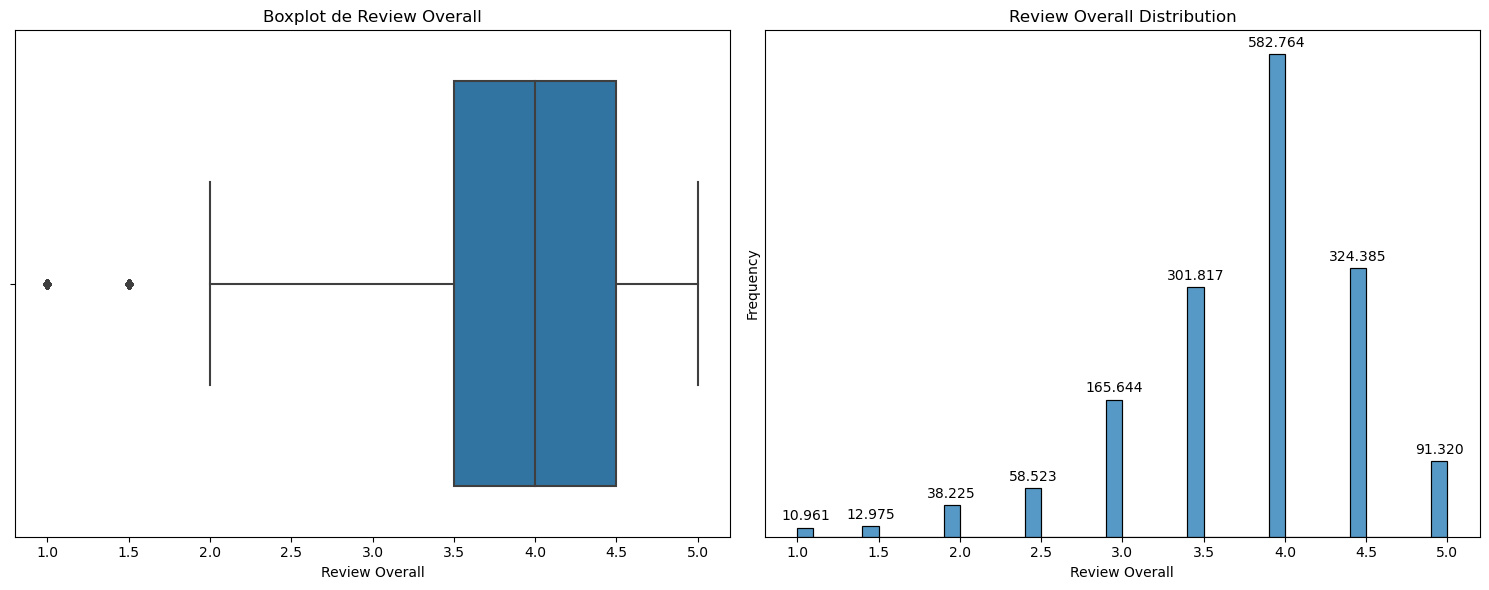

In [52]:
# Criar subplots lado a lado
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico 1 - Boxplot de 'review_overall'
sns.boxplot(data=data, x='review_overall', ax=axes[0])
axes[0].set_title('Boxplot de Review Overall')
axes[0].set_xlabel('Review Overall')

# Gráfico 2 - Histograma de 'review_overall'
histplot = sns.histplot(data=data, x='review_overall', binwidth=0.1, ax=axes[1])

# Adicionando rótulos de frequência ao histograma com separador de milhar (ponto)
for patch in histplot.patches:
    height = patch.get_height()
    if height > 0:
        histplot.annotate(f'{int(height):,}'.replace(",", "."), 
                          xy=(patch.get_x() + patch.get_width() / 2, height), 
                          xytext=(0, 3), 
                          textcoords="offset points", 
                          ha='center', va='bottom')

# Configurações do eixo Y e títulos
axes[1].yaxis.set_ticks([])  # Remover ticks do eixo Y no histograma
axes[1].set_title('Review Overall Distribution')
axes[1].set_xlabel('Review Overall')
axes[1].set_ylabel('Frequency')

# Ajustar espaçamento entre os gráficos
plt.tight_layout()

# Exibir o gráfico
plt.show()

#### 3.1.2 Sensorial Variables

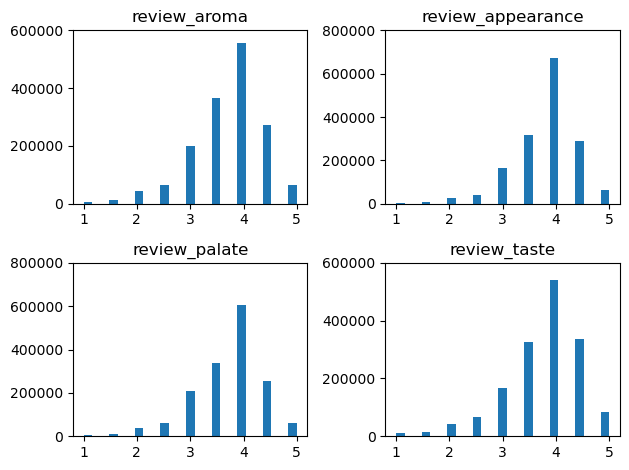

In [53]:
import matplotlib.pyplot as plt

# Agrupar os dados
grouped_view = data[['review_aroma', 'review_appearance', 'review_palate', 'review_taste']]

# Criar histogramas
axes = grouped_view.hist(bins=25)

# Remover rótulos de dados e linhas de grade
for ax in axes.flatten():
    # Ocultar as linhas de grade
    ax.grid(False)
    
    # Manter os valores no eixo y
    ax.set_yticks(ax.get_yticks())  # Isso garante que os rótulos do eixo y sejam mantidos

# Exibir o gráfico
plt.tight_layout()
plt.show()


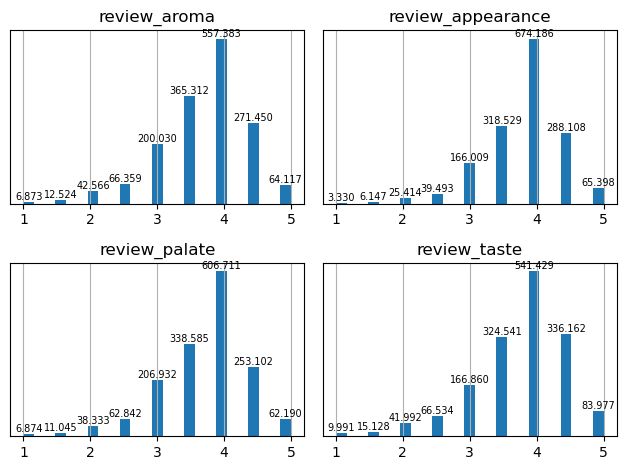

In [54]:
# Agrupar os dados
grouped_view = data[['review_aroma', 'review_appearance', 'review_palate', 'review_taste']]

# Criar histogramas
axes = grouped_view.hist(bins=25)

# Adicionar rótulos de dados, evitando zeros
for ax in axes.flatten():
    for p in ax.patches:  # Iterar sobre cada barra do histograma
        height = int(p.get_height())
        if height > 0:  # Verificar se a altura é maior que zero
            ax.annotate(f'{height:,}'.replace(',', '.'),  # Rótulo com a altura da barra e ponto como separador
                         (p.get_x() + p.get_width() / 2, height),  # Posição do rótulo
                         ha='center', va='bottom', fontsize=7)  # Ajustar o tamanho da fonte
    ax.set_yticks([])  # Ocultar o eixo y

# Exibir o gráfico
plt.tight_layout()
plt.show()

### 3.2 Bivariated Analysis

In [55]:
initial_date =  data['review_time'].min() 
final_date = data['review_time'].max()
delta_time = relativedelta(final_date, initial_date)

print(f"Initial Date: {initial_date}")
print(f"Final Date: {final_date}")
print(f"Time Interval: {delta_time.years} years and {delta_time.years} months")

Initial Date: 1996-08-22 00:00:01
Final Date: 2012-01-11 12:35:48
Time Interval: 15 years and 15 months


#### 3.2.1 Response Variable

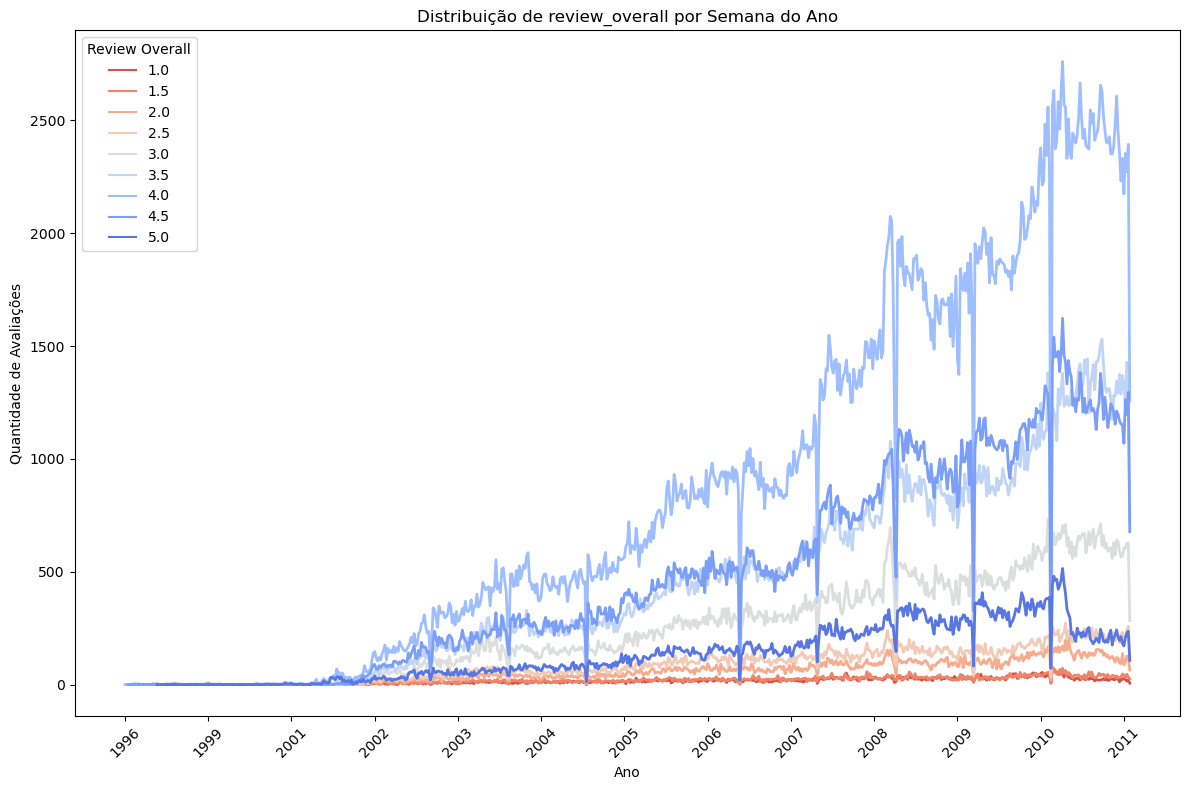

In [56]:
# Agrupando os dados por 'year_week' e 'review_taste'
freq_data = data.groupby(['year_week', 'review_overall']).size().reset_index(name='count')

# Convertendo 'year_week' para uma data completa
freq_data['date'] = pd.to_datetime(freq_data['year_week'] + '-1', format='%Y-%W-%w')  

# Extraindo o ano
freq_data['year'] = freq_data['date'].dt.year

# Criar o gráfico de linha
palette = sns.color_palette("coolwarm_r", n_colors=9)
plt.figure(figsize=(12, 8))

# Gráfico de linha com 'hue' para 'review_taste'
sns.lineplot(data=freq_data, x='year_week', y='count', hue='review_overall', palette=palette, linewidth=2)

# Ajustar o rótulo dos eixos e título
plt.xlabel('Ano')
plt.ylabel('Quantidade de Avaliações')
plt.title('Distribuição de review_overall por Semana do Ano')

# Gerar rótulos anuais no eixo X
unique_weeks = freq_data['year_week'].unique()
unique_quarters = freq_data.groupby('year_week')['year'].first()

# Ajustar os ticks do eixo X para todos os trimestres
plt.xticks(ticks=unique_weeks[::len(unique_weeks)//12], labels=unique_quarters[::len(unique_weeks)//12].astype(str), rotation=45, fontsize=10)

# Remover linhas de grade
plt.grid(False)

# Legenda
plt.legend(title='Review Overall', loc='upper left')

plt.tight_layout()
plt.show()

#### 3.2.2 Sensorial Variables

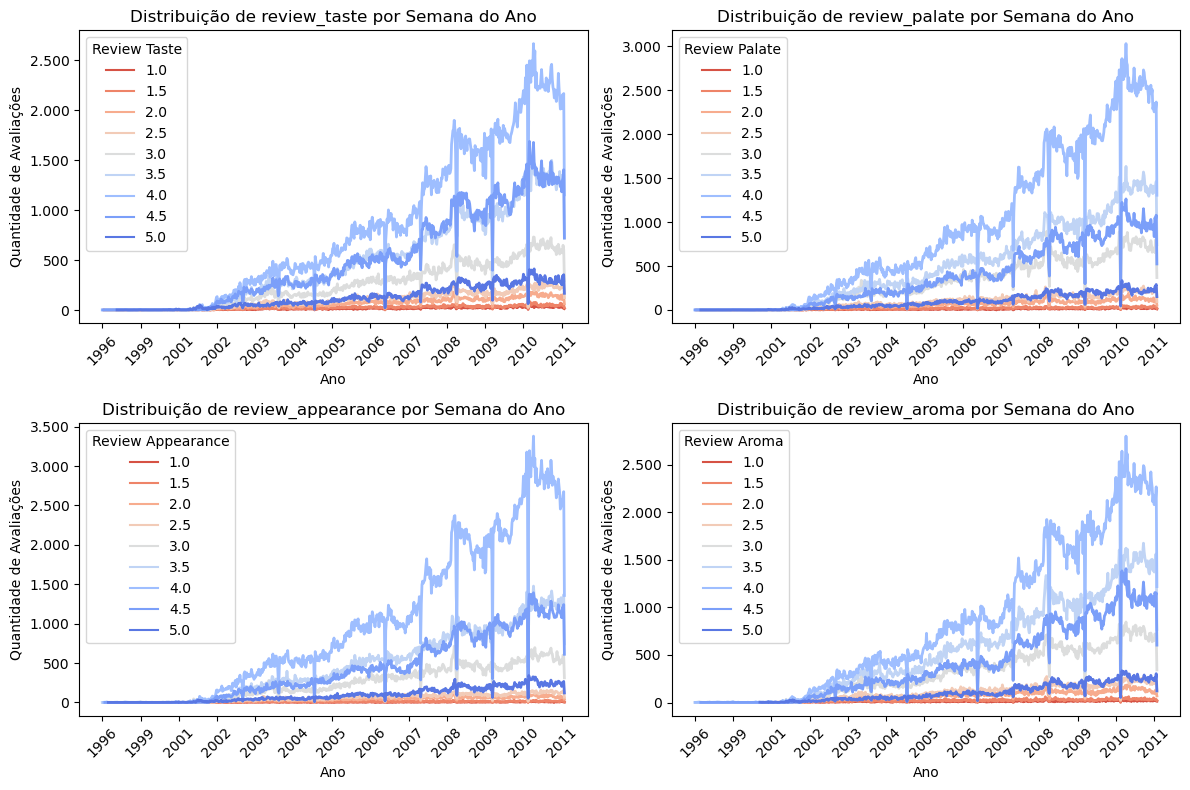

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import FuncFormatter

# Função para formatar os números com ponto como separador de milhar
def format_thousands(x, pos):
    return f'{int(x):,}'.replace(',', '.')

# Criar uma figura com 2 linhas e 2 colunas
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()  # Transformar a matriz de eixos em um array unidimensional

# Lista dos títulos e variáveis de review
titles = ['Distribuição de review_taste por Semana do Ano', 
          'Distribuição de review_palate por Semana do Ano', 
          'Distribuição de review_appearance por Semana do Ano', 
          'Distribuição de review_aroma por Semana do Ano']
reviews = ['review_taste', 'review_palate', 'review_appearance', 'review_aroma']

for i, review in enumerate(reviews):
    # Agrupando os dados por 'year_week' e a variável de review
    freq_data = data.groupby(['year_week', review]).size().reset_index(name='count')
    
    # Convertendo 'year_week' para uma data completa
    freq_data['date'] = pd.to_datetime(freq_data['year_week'] + '-1', format='%Y-%W-%w')  
    freq_data['year'] = freq_data['date'].dt.year  # Extraindo o ano

    # Gráfico de linha com 'hue' para a variável de review
    palette = sns.color_palette("coolwarm_r", n_colors=9)
    sns.lineplot(data=freq_data, x='year_week', y='count', hue=review, palette=palette, linewidth=2, ax=axes[i])

    # Ajustar o rótulo dos eixos e título
    axes[i].set_xlabel('Ano')
    axes[i].set_ylabel('Quantidade de Avaliações')
    axes[i].set_title(titles[i])

    # Gerar rótulos anuais no eixo X
    unique_weeks = freq_data['year_week'].unique()
    unique_quarters = freq_data.groupby('year_week')['year'].first()
    
    # Ajustar os ticks do eixo X
    axes[i].set_xticks(ticks=unique_weeks[::len(unique_weeks)//12])
    axes[i].set_xticklabels(unique_quarters[::len(unique_weeks)//12].astype(str), rotation=45, fontsize=10)

    # Remover linhas de grade
    axes[i].grid(False)

    # Formatar os valores do eixo Y com ponto como separador de milhar
    axes[i].yaxis.set_major_formatter(FuncFormatter(format_thousands))

    # Legenda
    axes[i].legend(title=review.replace('_', ' ').title(), loc='upper left')

# Ajustar layout
plt.tight_layout()
plt.show()

### 3.3 Multivariated Analysis

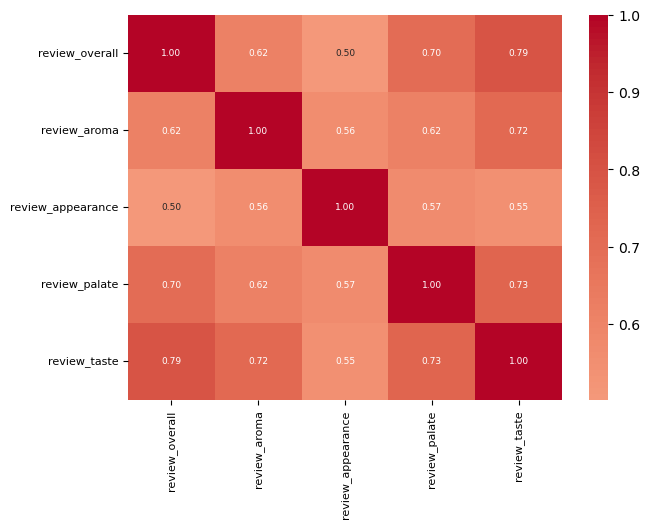

In [58]:
num_attributes = num_attributes[[
                                 'review_overall', 
                                 'review_aroma', 
                                 'review_appearance', 
                                 'review_palate',
                                 'review_taste'
                                 ]]

# Configuração da figura
plt.figure(figsize=(7, 5))

# Calculando a correlação
correlation = num_attributes.corr(method='pearson')

# Criando o heatmap com valores reduzidos e fonte ajustada
sns.heatmap(correlation, annot=True, fmt='.2f', annot_kws={"size": 6.5}, 
            cmap='coolwarm', center=0) 

plt.xticks(size=8) 
plt.yticks(size=8) 
plt.show()


## 4 Data Preparation

### 4.1 Variables Selection

In [59]:
X = data[['review_aroma','review_appearance','review_taste']]
X = (X*2) - 1
X = X.astype('string')

### 4.3 Get Dummies

In [60]:
X_dummies = pd.get_dummies(X, drop_first=True)

### 4.4 Remoção categoria

In [61]:
# cols = ['review_aroma_10', 'review_aroma_2', 'review_aroma_3', 'review_aroma_1', 'review_aroma_4',
#         'review_aroma_5', 'review_aroma_6', 'review_aroma_7', 'review_aroma_8',
#         'review_aroma_9', 'review_taste_10', 'review_taste_2', 'review_taste_3', 'review_taste_1',
#         'review_taste_4', 'review_taste_5', 'review_taste_6', 'review_taste_7',
#         'review_taste_8', 'review_taste_9', 'review_palate_10',
#         'review_palate_2', 'review_palate_3', 'review_palate_4', 'review_palate_1',
#         'review_palate_5', 'review_palate_6', 'review_palate_7',
#         'review_palate_8', 'review_palate_9', 'review_appearance_10', 'review_appearance_1',
#         'review_appearance_2', 'review_appearance_3', 'review_appearance_4',
#         'review_appearance_5', 'review_appearance_6', 'review_appearance_7',
#         'review_appearance_8', 'review_appearance_9']

# # Removendo colunas que contenham '_8'
# cols_to_keep = [col for col in cols if '_1' not in col]

# # Atualizando o DataFrame 'data' com apenas as colunas que queremos manter
# X_dummies = X_dummies[cols_to_keep]

# # Verificando as colunas restantes
# print(X_dummies.columns)


### 4.4 Response Variable

In [62]:
data['review_overall'] = (data['review_overall'] * 2) - 1
y = 'review_overall'
data[y] = data[y].astype('int')
y = data[y]

### 4.5 Checking Sizes

In [63]:
print(f"y Shape: {y.shape}")
print(f"X Shape: {X_dummies.shape}")

y Shape: (1586614,)
X Shape: (1586614, 24)


### 4.6 Multicolinearity check

In [64]:
df=pd.concat([y, X_dummies], axis=1)

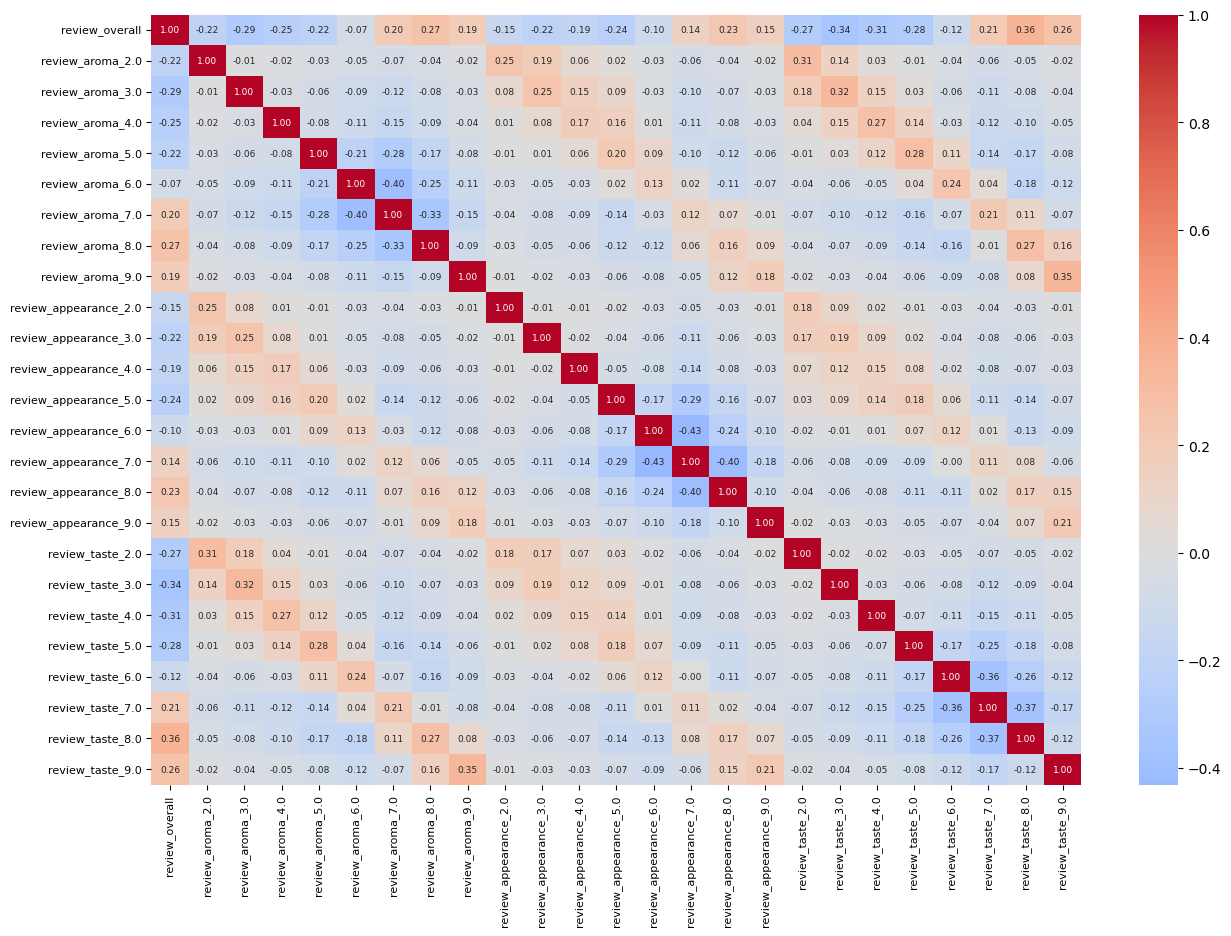

In [65]:
plt.figure(figsize=(15, 10))

# Calculando a correlação
correlation = df.corr(method='pearson')

# Criando o heatmap com valores reduzidos e fonte ajustada
sns.heatmap(correlation, annot=True, fmt='.2f', annot_kws={"size": 6.5}, 
            cmap='coolwarm', center=0) 

plt.xticks(size=8) 
plt.yticks(size=8) 
plt.show()


In [66]:
# Aplicando a função
vif_data = calculate_vif(X_dummies)
vif_data

c:\Users\Alexandre\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


,feature,VIF
0,review_aroma_2.0,0.06
1,review_aroma_3.0,0.02
2,review_aroma_4.0,0.01
3,review_aroma_5.0,0.02
4,review_aroma_6.0,0.00
5,review_aroma_7.0,0.02
6,review_aroma_8.0,0.02
7,review_aroma_9.0,0.03
8,review_appearance_2.0,0.00
9,review_appearance_3.0,0.01


#### Train Test Split

In [78]:
# Supondo que 'y' seja a variável resposta e 'X_dummies' sejam as variáveis explicativas
# Separando os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_dummies, y, test_size=0.2, random_state=42)

### REGRESSÃO LOGISTICA ORDINAL - NÃO REQUER CONSTANTE

In [69]:
mod_log = OrderedModel(y_train,
                        X_train,
                        distr='logit')

In [70]:
res_log = mod_log.fit(method='bfgs', disp=True)
res_log.summary()

Optimization terminated successfully.
         Current function value: 1.223282
         Iterations: 213
         Function evaluations: 214
         Gradient evaluations: 214


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:         review_overall   Log-Likelihood:            -1.5527e+06
Model:                   OrderedModel   AIC:                         3.105e+06
Method:            Maximum Likelihood   BIC:                         3.106e+06
Date:                Mon, 07 Oct 2024                                         
Time:                        15:47:32                                         
No. Observations:             1269291                                         
Df Residuals:                 1269259                                         
Df Model:                          24                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
review_aroma_2.0          0.5119      0.036     14.053      0.000       0.440       0.583
review_aroma_3.0          0.6611      0.034     19.247      0.000       0.594       0.728
review_aroma_4.0          0.7262      0.035     20.891      0.000       0.658       0.794
review_aroma_5.0          0.8545      0.035     24.751      0.000       0.787       0.922
review_aroma_6.0          0.9633      0.035     27.843      0.000       0.895       1.031
review_aroma_7.0          1.1546      0.035     33.323      0.000       1.087       1.223
review_aroma_8.0          1.4180      0.035     40.659      0.000       1.350       1.486
review_aroma_9.0          1.8157      0.036     50.575      0.000       1.745       1.886
review_appearance_2.0     0.3064      0.052      5.882      0.000       0.204       0.409
review_appearance_3.0     0.2259      0.047      4.796      0.000       0.134       0.318
review_appearance_4.0     0.2284      0.047      4.860      0.000       0.136       0.321
review_appearance_5.0     0.2915      0.046      6.294      0.000       0.201       0.382
review_appearance_6.0     0.4263      0.046      9.203      0.000       0.335       0.517
review_appearance_7.0     0.6808      0.046     14.707      0.000       0.590       0.772
review_appearance_8.0     1.0024      0.046     21.585      0.000       0.911       1.093
review_appearance_9.0     1.4173      0.047     30.086      0.000       1.325       1.510
review_taste_2.0          1.7998      0.031     58.139      0.000       1.739       1.860
review_taste_3.0          3.4859      0.031    112.541      0.000       3.425       3.547
review_taste_4.0          5.0152      0.032    157.474      0.000       4.953       5.078
review_taste_5.0          6.6676      0.032    208.120      0.000       6.605       6.730
review_taste_6.0          8.2334      0.032    255.333      0.000       8.170       8.297
review_taste_7.0          9.7988      0.032    302.461      0.000       9.735       9.862
review_taste_8.0         10.9967      0.033    336.854      0.000      10.933      11.061
review_taste_9.0         12.3241      0.034    366.291      0.000      12.258      12.390
1/2                       1.2530      0.047     26.702      0.000       1.161       1.345
2/3                       0.3723      0.010     39.014      0.000       0.354       0.391
3/4                       0.6852      0.006    121.812      0.000       0.674       0.696
4/5                       0.3968      0.004     89.188      0.000       0.388       0.406
5/6                       0.7255      0.003    269.125      0.000       0.720       0.731
6/7                       0.6559      0.002    338.280      0.000       0.652       0.660
7/8                       0.9570      0.001    699.710      0.000       0.954       0.960
8/9                       0.8606      0.002    448.001      0.000       0.857       0.864
============

In [79]:
#predict
y_test_pred_prob = res_log.predict(X_test)

#transformando X em uma coluna para comparar e somando 1 pois começa no 0 os indices
y_pred_test = np.argmax(y_test_pred_prob.values, axis=1) + 1

#adequando a variavel resposta
y_test = y_test.values.flatten()

#calculando a acuracia
accuracy = accuracy_score(y_test, y_pred_test)

In [80]:
accuracy

0.4945276579384413

In [81]:
y_test[0:20]

array([7, 4, 7, 8, 9, 6, 5, 3, 6, 7, 6, 8, 8, 8, 7, 7, 8, 8, 6, 7])

In [82]:
y_pred_test[0:20]

array([7, 5, 6, 7, 8, 7, 5, 5, 7, 7, 5, 6, 7, 8, 7, 7, 7, 7, 7, 7],
      dtype=int64)

In [86]:
res_log.information()

AttributeError: 'OrderedResults' object has no attribute 'information'

### REGRESSÃO LOGISTICA MULTINOMIAL - REQUER CONSTANTE

In [ ]:
# Adicionando uma constante para o modelo
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

In [ ]:
# Treinando o modelo de regressão logística ordinal
model = sm.MNLogit(y_train, X_train_const)
result = model.fit()

# Resumo do modelo
print(result.summary())

In [482]:
y_pred_prob = result.predict(X_test_const)

In [488]:
y_pred_prob['max']= y_pred_prob.max(axis=1)

y_pred_class['result'] = y_pred_prob.idxmax(axis=1) + 1

In [489]:
y_pred_class

,0,result
859964,1,8
581443,1,6
1270456,1,7
477415,1,7
1408999,1,7
...,...,...
783503,1,7
1397471,1,8
1577831,1,8
1463448,1,7


In [495]:
y_test

859964     7
581443     4
1270456    7
477415     8
1408999    9
          ..
783503     9
1397471    8
1577831    7
1463448    7
1270199    7
Name: review_overall, Length: 317323, dtype: int32

In [390]:

# Obtendo as probabilidades previstas para o conjunto de teste
y_pred_prob = result.predict(X_test_const)

# Encontrando a classe prevista (categoria com maior probabilidade)
y_pred_class = np.argmax(y_pred_prob, axis=1) + 1  # +1 pois o índice começa em 0

Calculando a acurácia
accuracy = accuracy_score(y_test, y_pred_class)
print("Acurácia:", accuracy)

# # Criando a matriz de confusão
# conf_matrix = confusion_matrix(y_test, y_pred_class)

# # Visualizando a matriz de confusão
# plt.figure(figsize=(10, 8))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Matriz de Confusão')
# plt.show()


ValueError: Shape of passed values is (317323, 1), indices imply (317323, 9)

In [389]:
a = np.argmax(y_pred_prob, axis=1)

ValueError: Shape of passed values is (317323, 1), indices imply (317323, 9)

In [388]:
a

1404

In [370]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.distributions.empirical_distribution import ECDF
import numpy as np

model = smf.mnlogit(formula='y ~ review_aroma_10 + review_aroma_2 + review_aroma_3 + review_aroma_4 + review_aroma_5 + review_aroma_6 + review_aroma_7 + review_aroma_8 + review_aroma_9 + review_taste_10 + review_taste_2 + review_taste_3 + review_taste_4 + review_taste_5 + review_taste_6 + review_taste_7 + review_taste_8 + review_taste_9 + review_palate_10 + review_palate_2 + review_palate_3 + review_palate_4 + review_palate_5 + review_palate_6 + review_palate_7 + review_palate_8 + review_palate_9 + review_appearance_10 + review_appearance_2 + review_appearance_3 + review_appearance_4 + review_appearance_5 + review_appearance_6 + review_appearance_7 + review_appearance_8 + review_appearance_9', 
                    data=pd.concat([y, X_dummies], axis=1)).fit()

# Realizar o teste de Brant
def brant_test(model, data):
    """
    Realiza o teste de Brant para verificar a proporcionalidade das odds
    em um modelo de regressão logística ordinal.
    
    Args:
        model: O modelo ajustado (statsmodels).
        data: DataFrame com as variáveis independentes e dependentes.

    Returns:
        resultados: Um DataFrame com os resultados do teste.
    """
    # Resumo dos parâmetros
    params = model.params
    results = {}

    # Obtenção dos valores de logit
    logit_values = model.predict(data)

    for i, param in enumerate(params.index[1:]):  # Ignora a constante
        # Teste de Brant
        # Calculando o valor de chi-quadrado
        chi_squared = np.sum((logit_values[:, i] - np.mean(logit_values[:, i]))**2)
        p_value = 1 - sm.stats.chisquare(logit_values[:, i])[1]

        results[param] = {'chi_squared': chi_squared, 'p_value': p_value}

    return pd.DataFrame(results).T

# Executa o teste de Brant
brant_results = brant_test(model, pd.concat([y, X_dummies], axis=1))

# Exibe os resultados
print(brant_results)

PatsyError: Error evaluating factor: NameError: name 'review_palate_5' is not defined
    y ~ review_aroma_10 + review_aroma_2 + review_aroma_3 + review_aroma_4 + review_aroma_5 + review_aroma_6 + review_aroma_7 + review_aroma_8 + review_aroma_9 + review_taste_10 + review_taste_2 + review_taste_3 + review_taste_4 + review_taste_5 + review_taste_6 + review_taste_7 + review_taste_8 + review_taste_9 + review_palate_10 + review_palate_2 + review_palate_3 + review_palate_4 + review_palate_5 + review_palate_6 + review_palate_7 + review_palate_8 + review_palate_9 + review_appearance_10 + review_appearance_2 + review_appearance_3 + review_appearance_4 + review_appearance_5 + review_appearance_6 + review_appearance_7 + review_appearance_8 + review_appearance_9
                                                                                                                                                                                                                                                                                                                                                                                                     ^^^^^^^^^^^^^^^

### 4.4 Train/Test split

In [144]:
X_train_Scaled, X_test_Scaled, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print(X_train_Scaled.shape, X_test_Scaled.shape, y_train.shape, y_test.shape)

(1269279, 4) (317320, 4) (1269279,) (317320,)


### 4.5 Preparing X for Training

In [145]:
X_train_Scaled_Data_Frame = pd.DataFrame(X_train_Scaled)
X_test_Scaled_Data_Frame = pd.DataFrame(X_test_Scaled)

## 5 Model Training

###### Nota: Decidimos não utilizar a métrica MAPE pois a distribuição dos dados na variável resposta é desbalanceada e os números são muito pequenos, o que, após o cross validation ser executado, resulta em um disparo do indicador. Elencando soluções, poderíamos efetuar o cross validation estratificado, ou multiplicar os valores da variável resposta por algum fator, mas não se justifica por termos outras métricas mais relevantes que serão adotadas a seguir: 

##### MAE - Mean Absolute Error

##### MSE - Mean Squared Error

##### RMSE - Root Mean Squared Error

### 5.1 Linear Regressor

In [146]:
#modelo
linear_regressor = LinearRegression().fit(X_train_Scaled, y_train)

#predição
linear_regressor_pred = linear_regressor.predict(X_test_Scaled)

#arredondamento para ficar nos padrões 0,5 em 0,5
linear_regressor_pred_rounded = np.round(linear_regressor_pred / 0.5) * 0.5

#avaliando
linear_regressor_result = ml_error('Linear Regressor', y_test, linear_regressor_pred_rounded)

#exibindo o resultado
linear_regressor_result

,Model Name,MAE,MSE,RMSE,R²
0,Linear Regressor,0.29,0.20,0.45,0.62


In [147]:
result_df = pd.DataFrame({
    'True Value': y_test,
    'Predicted Value': linear_regressor_pred_rounded
})

result_df['Correct'] = result_df['True Value'] == result_df['Predicted Value']

# Calculando o percentual de acerto
accuracy = result_df['Correct'].mean() * 100
print(f'Percentual de acerto: {accuracy:.2f}%')

Percentual de acerto: 50.03%


#### 5.1.1 Linear Regressor Cross Validation

In [148]:
linear_regressor_cv = cross_validation(X_test_Scaled_Data_Frame, y_test, linear_regressor, kfold=5)

linear_regressor_cv['model'] = "Linear Regression"

### 5.2 Decision Tree Regressor

In [149]:
#definindo parâmetros
decision_tree_regressor = DecisionTreeRegressor(
    max_depth=8,             
    min_samples_split=5,     
    min_samples_leaf=5,       
    random_state=42
)

#modelo
decision_tree_regressor.fit(X_train_Scaled, y_train)

#predição
decision_tree_regressor_pred = decision_tree_regressor.predict(X_test_Scaled)

#arredondamento para ficar nos padrões 0,5 em 0,5
decision_tree_regressor_pred_rounded = np.round(decision_tree_regressor_pred / 0.5) * 0.5

#avaliando
decision_tree_result = ml_error('Decision Tree Regression', y_test, decision_tree_regressor_pred_rounded)

#exibindo o resultado
decision_tree_result


,Model Name,MAE,MSE,RMSE,R²
0,Decision Tree Regression,0.29,0.19,0.44,0.63


In [150]:
result_df = pd.DataFrame({
    'True Value': y_test,
    'Predicted Value': decision_tree_regressor_pred_rounded
})

result_df['Correct'] = result_df['True Value'] == result_df['Predicted Value']

# Calculando o percentual de acerto
accuracy = result_df['Correct'].mean() * 100
print(f'Percentual de acerto: {accuracy:.2f}%')

Percentual de acerto: 51.03%


#### 5.2.1 Decision Tree Cross Validation

In [151]:
decision_tree_cv = cross_validation(X_test_Scaled_Data_Frame, y_test, decision_tree_regressor, kfold=5)

decision_tree_cv['model'] = "Decision Tree"

### 5.2 XGBoost Regressor

In [152]:
#definindo parâmetros
xgb_regressor = XGBRegressor(
    max_depth=10,               # Profundidade máxima da árvore
    n_estimators=100,          # Número de árvores no ensemble
    learning_rate=0.2,         # Taxa de aprendizado
    subsample=0.8,             # Proporção de amostras usadas para treinar cada árvore
    colsample_bytree=0.8,      # Proporção de features usadas para cada árvore
    random_state=22
)

#modelo
xgb_regressor.fit(X_train_Scaled, y_train)

#predição
xgb_regressor_pred = xgb_regressor.predict(X_test_Scaled)

#arredondamento para ficar nos padrões 0,5 em 0,5
xgb_regressor_pred_rounded = np.round(xgb_regressor_pred / 0.5) * 0.5

#avaliando
xgb_regressor_result = ml_error('XGBoost Regression', y_test, xgb_regressor_pred_rounded)

#exibindo o resultado
xgb_regressor_result

,Model Name,MAE,MSE,RMSE,R²
0,XGBoost Regression,0.29,0.19,0.44,0.63


#### 5.2.a XGBoost Feature Importance

In [153]:
xgb_regressor.feature_importances_

array([0.00379279, 0.90532243, 0.08471246, 0.00617236], dtype=float32)

In [154]:
result_df = pd.DataFrame({
    'True Value': y_test,
    'Predicted Value': xgb_regressor_pred_rounded
})

result_df['Correct'] = result_df['True Value'] == result_df['Predicted Value']

# Calculando o percentual de acerto
accuracy = result_df['Correct'].mean() * 100
print(f'Percentual de acerto: {accuracy:.2f}%')

Percentual de acerto: 51.10%


#### 5.2.2 XGBoost Cross Validation

In [155]:
xgb_regressor_cv = cross_validation(X_test_Scaled_Data_Frame, y_test, xgb_regressor, kfold=5)

xgb_regressor_cv['model'] = "XGBoost Regressor"

### 5.3 Random Forest Regressor

In [156]:
#definindo parâmetros
rf_regressor = RandomForestRegressor(
    n_estimators=100,          # Número de árvores na floresta
    max_depth=10,              # Profundidade máxima das árvores
    min_samples_split=10,      # Número mínimo de amostras para dividir um nó
    min_samples_leaf=5,        # Número mínimo de amostras por folha
    random_state=42
)

#modelo
rf_regressor.fit(X_train_Scaled, y_train)

#predição
rf_regressor_pred = rf_regressor.predict(X_test_Scaled)

#arredondamento para ficar nos padrões 0,5 em 0,5
rf_regressor_pred_rounded = np.round(rf_regressor_pred / 0.5) * 0.5

#avaliando
rf_regressor_result = ml_error('Random Forest Regression', y_test, rf_regressor_pred_rounded)

#exibindo o resultado
rf_regressor_result

,Model Name,MAE,MSE,RMSE,R²
0,Random Forest Regression,0.29,0.19,0.44,0.63


In [157]:
result_df = pd.DataFrame({
    'True Value': y_test,
    'Predicted Value': rf_regressor_pred_rounded
})

result_df['Correct'] = result_df['True Value'] == result_df['Predicted Value']

# Calculando o percentual de acerto
accuracy = result_df['Correct'].mean() * 100
print(f'Percentual de acerto: {accuracy:.2f}%')

Percentual de acerto: 51.11%


In [158]:
rf_regressor.feature_importances_

array([0.00396932, 0.93863848, 0.05262562, 0.00476658])

#### 5.3.1 Random Forest Cross Validation

In [159]:
rf_regressor_cv = cross_validation(X_test_Scaled_Data_Frame, y_test, rf_regressor, kfold=5)

rf_regressor_cv['model'] = "Random Forest"

### 5.4 Results

#### 5.4.1 Initial Models

In [160]:
model_results = pd.concat([linear_regressor_result, decision_tree_result, rf_regressor_result, xgb_regressor_result], axis=0)
print(model_results)

                 Model Name  MAE  MSE  RMSE   R²
0          Linear Regressor 0.29 0.20  0.45 0.62
0  Decision Tree Regression 0.29 0.19  0.44 0.63
0  Random Forest Regression 0.29 0.19  0.44 0.63
0        XGBoost Regression 0.29 0.19  0.44 0.63


#### 5.4.2 Cross Validation Models

In [161]:
cv_model_results = pd.concat([linear_regressor_cv, decision_tree_cv, rf_regressor_cv, xgb_regressor_cv], axis=0)
print(cv_model_results)

      MAE  MSE  RMSE   R²              model
Mean 0.31 0.18  0.42 0.66  Linear Regression
Std  0.00 0.00  0.00 0.00  Linear Regression
Mean 0.31 0.17  0.42 0.67      Decision Tree
Std  0.00 0.00  0.00 0.00      Decision Tree
Mean 0.31 0.17  0.42 0.67      Random Forest
Std  0.00 0.00  0.00 0.00      Random Forest
Mean 0.31 0.17  0.42 0.66  XGBoost Regressor
Std  0.00 0.00  0.00 0.00  XGBoost Regressor


## 6 Hiperparameter Fine Tunning

### 6.1 XGBoost Fine Tunning

In [162]:
# param_grid = {
#     'n_estimators': [100, 200, 300],  # Número de árvores
#     'max_depth': [3, 5, 7, 9],        # Profundidade máxima da árvore
#     'min_child_weight': [1, 3, 5],    # Importante para evitar overfitting
#     'learning_rate': [0.01, 0.1, 0.2], # Taxa de aprendizado
# }

# xgb_regressor = XGBRegressor()


# grid_search = GridSearchCV(estimator=xgb_regressor, param_grid=param_grid, 
#                            scoring='neg_mean_absolute_error', 
#                            cv=5, n_jobs=-1, verbose=1)

# grid_search.fit(X_train_Scaled, y_train)

# print("Melhores parâmetros encontrados:", grid_search.best_params_)
# print("Melhor MAE:", -grid_search.best_score_)
